In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(15,8)})
from datetime import datetime, timedelta
import re
import json
import spacy
import string
import wordcloud 
from wordcloud import WordCloud
from causalimpact import CausalImpact
from scipy.stats import ttest_ind
import statsmodels.formula.api as smf

# Local Modules
import matplotlib as mpl
import matplotlib.font_manager as font_manager
from matplotlib.lines import Line2D


# Granger test between GTrends views and tweets
import statsmodels.api as sm

## Data parsing

In [2]:
# build a personalyze data parser
custom_date = lambda x: datetime.strptime(x.split()[0], '%Y-%m-%d')
df = pd.read_csv('extra_material/tweets.csv', parse_dates=['date'], date_parser=custom_date)

/var/folders/g4/t17nc9bs2zqcfjn9vq_f93b80000gn/T/ipykernel_93383/2600807054.py:3: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df = pd.read_csv('extra_material/tweets.csv', parse_dates=['date'], date_parser=custom_date)


In [3]:
df_covid = df[df['date'] >= '2019-12-01']

In [4]:
time_span = pd.date_range(start = min(df_covid['date']), end = max(df_covid['date']), freq='D')

data=df_covid.copy()
data = pd.merge(data, pd.DataFrame(time_span, columns=['date']), on='date', how='right')
data.dropna(inplace=True)

In [5]:
nlp = spacy.load('en_core_web_sm')
spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS
print('Number of stop words: %d' % len(spacy_stopwords))

Number of stop words: 326


In [6]:
#all tweets in one string
result_text = ' '.join(data['text'])

def remove_stopwords(chunk):
    return ' '.join([token.text for token in chunk if (not token.is_stop)])

#the text we have is too big to process it at once, so we split it into chunks
chunk_size = 100000
chunks = [result_text[i:i+chunk_size] for i in range(0, len(result_text), chunk_size)]
processed_chunks = [nlp(chunk) for chunk in chunks]
processed_chunks_no_stopwords = [remove_stopwords(chunk) for chunk in processed_chunks]

#manually clean text from links, punctuation, etc.
clean = ' '.join(processed_chunks_no_stopwords)
clean= re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '',clean)#remove links
clean= clean.translate(str.maketrans('', '', string.punctuation))#remove punctuation
clean = clean.replace('amp', '')
clean = clean.replace('RT', '')
clean = clean.replace('realDonaldTrump', '')

## Sentiment analysis 

In [7]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/Etienne/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [8]:
data['scores'] = data['text'].apply(lambda Description: sid.polarity_scores(Description))  

#calculate the sentiment score which is a combination of positive, negative and neutral(not mean)
data['compound']  = data['scores'].apply(lambda score_dict: score_dict['compound'])
data['sentiment_type']=''
data.loc[data.compound>0,'sentiment_type']='POSITIVE'
data.loc[data.compound==0,'sentiment_type']='NEUTRAL'
data.loc[data.compound<0,'sentiment_type']='NEGATIVE'

## Covid related

In [9]:
#create a list of words related to covid
list_of_words = ['Covid19' ,'virus', 'vaccine', 'Flu', 'Covid', 'lockdown', 'pandemic', 'coronavirus', 'Coronavirus', 'Corona', 'corona', 'COVID19', 'COVID', 'covid', 'quarantine', 'Quarantine', 'quarentine', 'Quarentine', 'quarantined', 'Quarantined', 'quarentined', 'Quarentined', 'quarantining', 'Quarantining', 'quarentining', 'Quarentining', 'quarantines', 'Quarantines', 'quarentines', 'Quarentines', 'quarantine', 'Quarantine', 'quarentine', 'Quarentine', 'quarantining', 'Quarantining', 'quarentining', 'Quarentining', 'quarantines', 'Quarantines', 'quarentines', 'Quarentines', 'quarantine', 'Quarantine', 'quarentine', 'Quarentine', 'quarantining', 'Quarantining', 'quarentining', 'Quarentining', 'quarantines', 'Quarantines', 'quarentines', 'Quarentines', 'quarantine', 'Quarantine', 'quarentine', 'Quarentine', 'quarantining', 'Quarantining', 'quarentining', 'Quarentining', 'quarantines', 'Quarantines', 'quarentines', 'Quarentines']
data['covid_related'] = data['text'].apply(lambda x: True if any(word in x for word in list_of_words) else False)

data['covid_related'].value_counts()

covid_related
False    12874
True       644
Name: count, dtype: int64

In [10]:
#data where covid_related is true
data_covid_rel = data[data['covid_related']==1]
data_not_covid_rel = data[data['covid_related']==0]

t-test between covid related and non related mean of retweets :

In [11]:
data_covid_rel = data[data['covid_related']==1]
data_not_covid_rel = data[data['covid_related']==0]
comparison_covid = pd.DataFrame({'Covid related':data_covid_rel.retweets, 'Non covid related':data_not_covid_rel.retweets})

t_stat, p_value_covid = ttest_ind(data_covid_rel.retweets, data_not_covid_rel.retweets, equal_var=False)
print('The p-value of the t-test is', p_value_covid.round(5))

The p-value of the t-test is 0.0


## LeakTheory related

In [12]:
fake_news_leaktheory = ['China virus', 'china virus', 'chinavirus', 'Chinavirus', 'China Virus']
analyze_leaktheory = data['text'].apply(lambda x: True if any(word in x for word in fake_news_leaktheory) else False)

# create a new column with the result of the analysis
new_col = analyze_leaktheory.reindex(data.index, fill_value=False)
data['Leaktheory'] = new_col
print('Number of tweets talking about COVID-19 lab leak theory is: ', data['Leaktheory'].sum())


Number of tweets talking about COVID-19 lab leak theory is:  44


In [13]:
data_Leaktheory_rel = data[data['Leaktheory']==1]
data_not_Leaktheory_rel = data[data['Leaktheory']==0]
comparison_Leaktheory = pd.DataFrame({'Leaktheory related':data_Leaktheory_rel.retweets, 'Non Leaktheory related':data_not_Leaktheory_rel.retweets})
#sns.pointplot(data=comparison_Leaktheory, estimator='mean', errorbar=('ci', 95), color = 'r')
#plt.title('Comparison of retweets (errorbar = CI 95%)', size=13)
#plt.ylabel('Number of retweets', size=12)
#plt.show()
t_stat, p_value_Leaktheory = ttest_ind(data_Leaktheory_rel.retweets, data_not_Leaktheory_rel.retweets, equal_var=False)
print('The p-value is', p_value_Leaktheory.round(5))

The p-value is 2e-05


## Swine flu related

In [14]:
fake_news_swineflu = ['Swine', 'swine', 'H1N1', 'h1n1']
analyze_swineflu = data['text'].apply(lambda x: True if any(word in x for word in fake_news_swineflu) else False)

# create a new column with the result of the analysis
new_col = analyze_swineflu.reindex(data.index, fill_value=False)
data['Swineflu'] = new_col

In [15]:
data_Swineflu_rel = data[data['Swineflu']==1]
data_not_Swineflu_rel = data[data['Swineflu']==0]
comparison_Swineflu = pd.DataFrame({'Swineflu related':data_Swineflu_rel.retweets, 'Non Swineflu related':data_not_Swineflu_rel.retweets})

t_stat, p_value_Swineflu = ttest_ind(data_Swineflu_rel.retweets, data_not_Swineflu_rel.retweets, equal_var=False)
print('The p-value of the t-test is', p_value_Swineflu.round(5))

The p-value of the t-test is 0.00485


## Hydroxychloroquine related

In [16]:
fake_news = ['Hydroxychloroquine', 'hydroxychloroquine']
analyze = data['text'].apply(lambda x: True if any(word in x for word in fake_news) else False)

# create a new column with the result of the analysis
new_col = analyze.reindex(data.index, fill_value=False)
data['Hydroxychloroquine']=new_col

print('Number of tweets talking about Hydroxychloroquine is: ', data['Hydroxychloroquine'].sum())

Number of tweets talking about Hydroxychloroquine is:  22


In [17]:
data_Hydroxychloroquine_rel = data[data['Hydroxychloroquine']==1]
data_not_Hydroxychloroquine_rel = data[data['Hydroxychloroquine']==0]
comparison_Hydroxychloroquine = pd.DataFrame({'Hydroxychloroquine related':data_Hydroxychloroquine_rel.retweets, 'Non Hydroxychloroquine related':data_not_Hydroxychloroquine_rel.retweets})

t_stat, p_value_Hydroxychloroquine = ttest_ind(data_Hydroxychloroquine_rel.retweets, data_not_Hydroxychloroquine_rel.retweets, equal_var=False)
print('The p-value of the t-test is', p_value_Hydroxychloroquine.round(5))

The p-value of the t-test is 0.31876


## Biden related

In [18]:
biden = ['Joe Biden','biden','joe','Joe','Biden','sleepy']
analyze_biden = data['text'].apply(lambda x: True if any(word in x for word in biden) else False)

# create a new column with the result of the analysis
new_col = analyze_biden.reindex(data.index, fill_value=False)
data['biden'] = new_col
print('Number of tweets talking about biden is: ', data['biden'].sum())


Number of tweets talking about biden is:  1135


In [19]:
data_biden_rel = data[data['biden']==1]
data_not_biden_rel = data[data['biden']==0]
comparison_biden = pd.DataFrame({'biden related':data_biden_rel.retweets, 'Non biden related':data_not_biden_rel.retweets})

t_stat, p_value_biden = ttest_ind(data_biden_rel.retweets, data_not_biden_rel.retweets, equal_var=False)
print('The p-value of the t-test is', p_value_biden.round(5))

The p-value of the t-test is 0.0


## Democrats related

In [20]:
democrats = ['Democrats','democrats','Dems','dems']
analyze_democrats = data['text'].apply(lambda x: True if any(word in x for word in democrats) else False)

# create a new column with the result of the analysis
new_col = analyze_democrats.reindex(data.index, fill_value=False)
data['democrats'] = new_col
print('Number of tweets talking about democrats is: ', data['democrats'].sum())

Number of tweets talking about democrats is:  878


In [21]:
data_democrats_rel = data[data['democrats']==1]
data_not_democrats_rel = data[data['democrats']==0]
comparison_democrats = pd.DataFrame({'democrats related':data_democrats_rel.retweets, 'Non democrats related':data_not_democrats_rel.retweets})

t_stat, p_value_democrats = ttest_ind(data_democrats_rel.retweets, data_not_democrats_rel.retweets, equal_var=False)
print('The p-value of the t-test is', p_value_democrats.round(5))

The p-value of the t-test is 0.92457


## Vaccines related

In [22]:
vaccines = ['vaccines','Vaccines','vax','Vax','vaccin']
analyze_vaccines = data['text'].apply(lambda x: True if any(word in x for word in democrats) else False)

# create a new column with the result of the analysis
new_col = analyze_vaccines.reindex(data.index, fill_value=False)
data['vaccines'] = new_col
print('Number of tweets talking about vaccines of the t-test is: ', data['vaccines'].sum())

Number of tweets talking about vaccines of the t-test is:  878


In [23]:
data_vaccines_rel = data[data['vaccines']==1]
data_not_vaccines_rel = data[data['vaccines']==0]
comparison_vaccines = pd.DataFrame({'vaccines related':data_vaccines_rel.retweets, 'Non vaccines related':data_not_vaccines_rel.retweets})


t_stat, p_value_vaccines = ttest_ind(data_vaccines_rel.retweets, data_not_vaccines_rel.retweets, equal_var=False)
print('The p-value of the t-test is', p_value_vaccines.round(5))

The p-value of the t-test is 0.92457


## Aggregate results into more general categories:

In [24]:
data['is_fake_news'] = (data['Hydroxychloroquine']|data['Swineflu']|data['Leaktheory'])
data['is_democrats_related'] = (data['biden']|data['democrats'])

In [25]:
data['is_democrats_related'] .sum()

1936

In [26]:
data_fake_news_rel = data[data['is_fake_news']==1]
data_not_fake_news_rel = data[data['is_fake_news']==0]
comparison_fake_news = pd.DataFrame({'fake_news related':data_fake_news_rel.retweets, 'Non fake_news related':data_not_fake_news_rel.retweets})


t_stat, p_value_fake_news = ttest_ind(data_fake_news_rel.retweets, data_not_fake_news_rel.retweets, equal_var=False)
print('The p-value of the t-test is', p_value_fake_news.round(5))

The p-value of the t-test is 8e-05


## Plots of number of rewteets by topics:

[Text(0, 0.5, 'Number of retweets')]

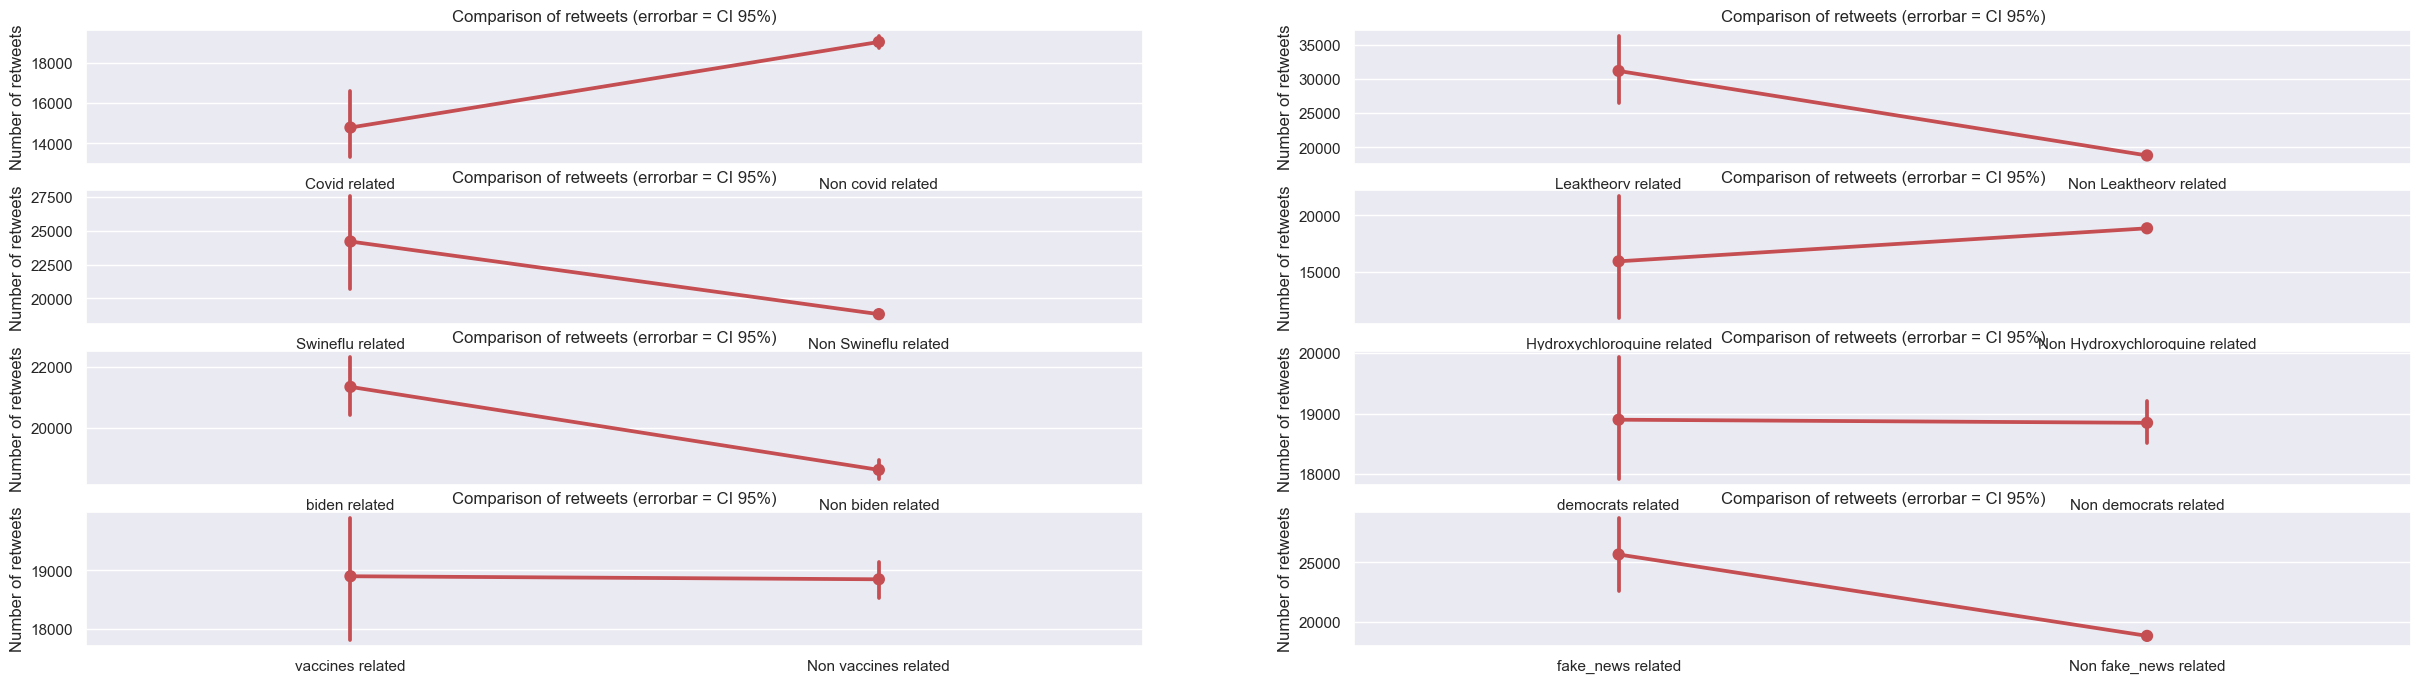

In [27]:
fig, axs = plt.subplots(4, 2,figsize=(30,8))

ax0 = sns.pointplot(data=comparison_covid, ax=axs[0, 0], estimator='mean', errorbar=('ci', 95), color = 'r')
ax0 .set(title='Comparison of retweets (errorbar = CI 95%)')
ax0 .set(ylabel='Number of retweets')

ax1 = sns.pointplot(data=comparison_Leaktheory,ax=axs[0, 1], estimator='mean', errorbar=('ci', 95), color = 'r')
ax1 .set(title='Comparison of retweets (errorbar = CI 95%)')
ax1 .set(ylabel='Number of retweets')

ax2 = sns.pointplot(data=comparison_Swineflu, ax=axs[1, 0], estimator='mean', errorbar=('ci', 95), color = 'r')
ax2 .set(title='Comparison of retweets (errorbar = CI 95%)')
ax2 .set(ylabel='Number of retweets')

ax3 = sns.pointplot(data=comparison_Hydroxychloroquine, ax= axs[1, 1], estimator='mean', errorbar=('ci', 95), color = 'r')
ax3 .set(title='Comparison of retweets (errorbar = CI 95%)')
ax3 .set(ylabel='Number of retweets')

ax4 = sns.pointplot(data=comparison_biden,ax=axs[2, 0], estimator='mean', errorbar=('ci', 95), color = 'r')
ax4 .set(title='Comparison of retweets (errorbar = CI 95%)')
ax4 .set(ylabel='Number of retweets')

ax5 = sns.pointplot(data=comparison_democrats, ax=axs[2, 1], estimator='mean', errorbar=('ci', 95), color = 'r')
ax5 .set(title='Comparison of retweets (errorbar = CI 95%)')
ax5 .set(ylabel='Number of retweets')

ax6 = sns.pointplot(data=comparison_vaccines, ax=axs[3, 0], estimator='mean', errorbar=('ci', 95), color = 'r')
ax6 .set(title='Comparison of retweets (errorbar = CI 95%)')
ax6 .set(ylabel='Number of retweets')

ax7 = sns.pointplot(data=comparison_fake_news, ax=axs[3, 1], estimator='mean', errorbar=('ci', 95), color = 'r')
ax7 .set(title='Comparison of retweets (errorbar = CI 95%)')
ax7 .set(ylabel='Number of retweets')

## Regression to disentangle categories into predicting the number of retweets:

In [28]:
mod_retweets = smf.ols(formula='retweets ~ C(is_democrats_related)+C(covid_related)+C(is_fake_news)', data=data)
res_retweets = mod_retweets.fit()
print(res_retweets.summary())

                            OLS Regression Results                            
Dep. Variable:               retweets   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     22.14
Date:                Tue, 12 Dec 2023   Prob (F-statistic):           2.71e-14
Time:                        10:35:50   Log-Likelihood:            -1.5163e+05
No. Observations:               13518   AIC:                         3.033e+05
Df Residuals:                   13514   BIC:                         3.033e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

In [29]:
mod_retweets = smf.ols(formula='retweets ~ C(covid_related)+C(is_fake_news)+C(sentiment_type)', data=data)

In [30]:
res_retweets = mod_retweets.fit()
print(res_retweets.summary())

                            OLS Regression Results                            
Dep. Variable:               retweets   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     29.59
Date:                Tue, 12 Dec 2023   Prob (F-statistic):           1.55e-24
Time:                        10:35:50   Log-Likelihood:            -1.5160e+05
No. Observations:               13518   AIC:                         3.032e+05
Df Residuals:                   13513   BIC:                         3.033e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

## Compare number of retweets per categories :

[Text(0.5, 0, 'Categories'), Text(0, 0.5, 'Number of rewtweets')]

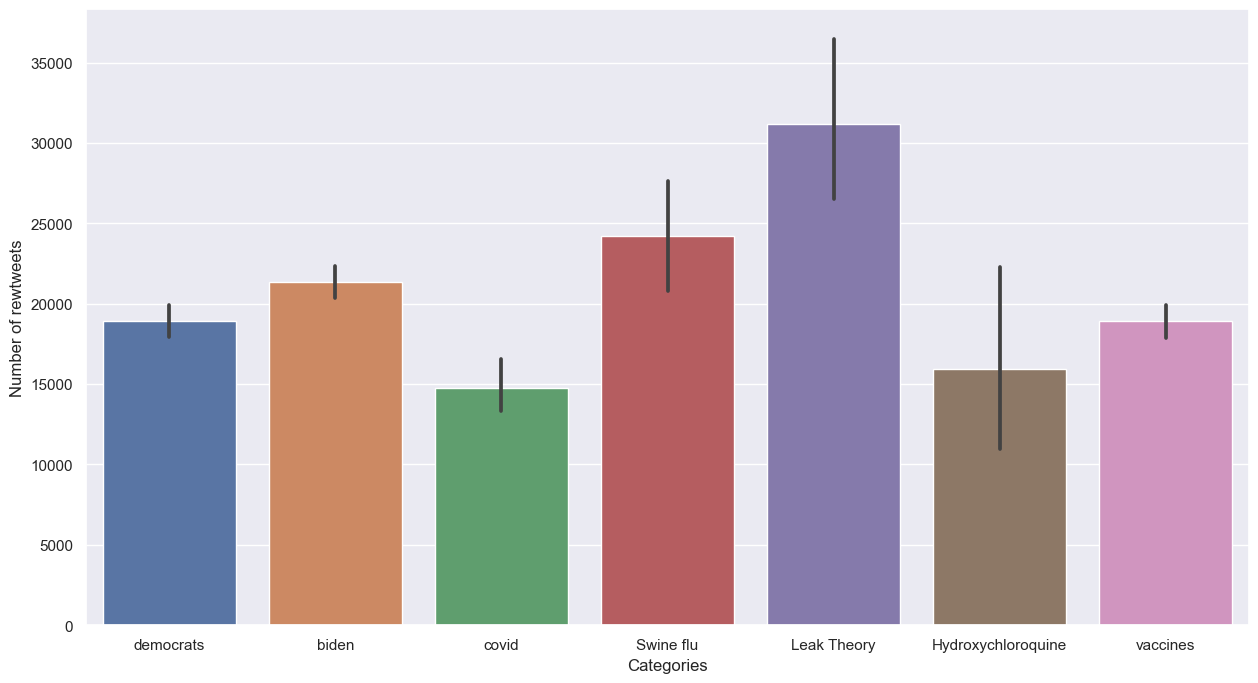

In [31]:
compare_retweets = pd.DataFrame({'democrats':data_democrats_rel.retweets,'biden':data_biden_rel.retweets,
                    'covid':data_covid_rel.retweets,'Swine flu':data_Swineflu_rel.retweets,
                     'Leak Theory':data_Leaktheory_rel.retweets,'Hydroxychloroquine':data_Hydroxychloroquine_rel.retweets,
                               'vaccines':data_vaccines_rel.retweets})

ax = sns.barplot(compare_retweets)
ax.set(xlabel='Categories', ylabel='Number of rewtweets')

[Text(0.5, 0, 'Categories'), Text(0, 0.5, 'Number of rewtweets')]

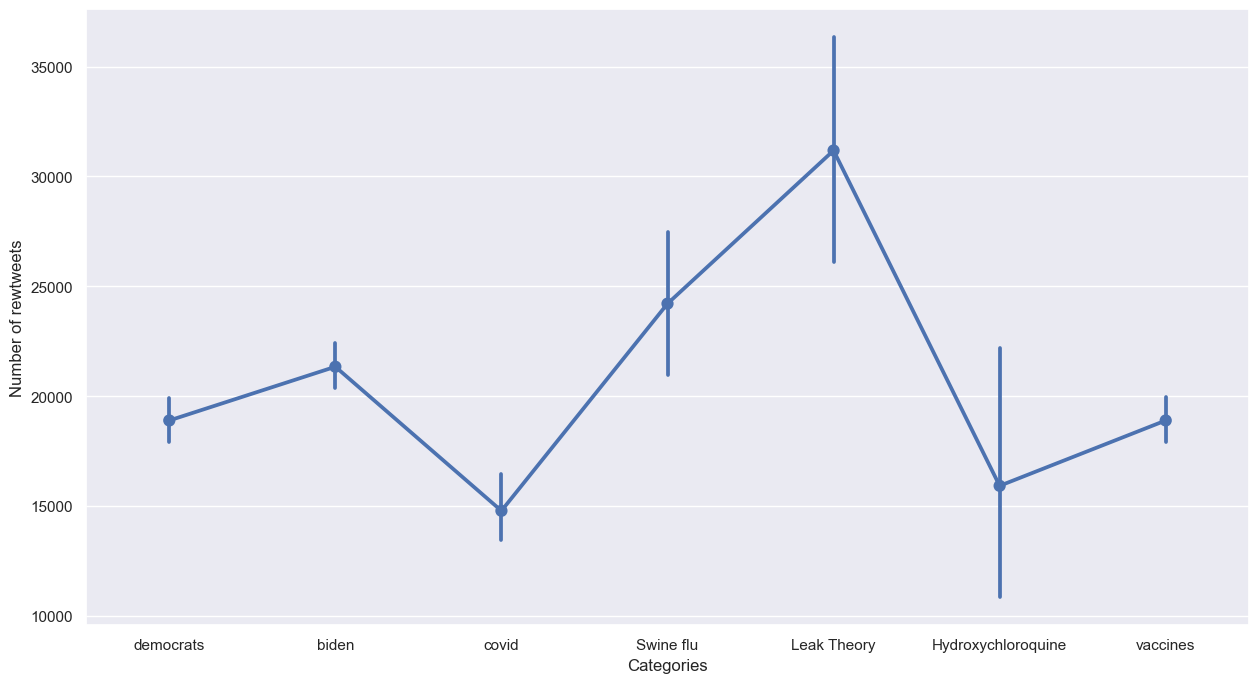

In [32]:
ax = sns.pointplot(compare_retweets)
ax.set(xlabel='Categories', ylabel='Number of rewtweets')

# Studying sentiment

Add one hot encoding of sentiment:

In [33]:
data =data.merge(pd.get_dummies(data['sentiment_type']), left_index=True, right_index=True)

## Sentiment distributions

sentiment_type
POSITIVE    6085
NEGATIVE    3789
NEUTRAL     3644
Name: count, dtype: int64


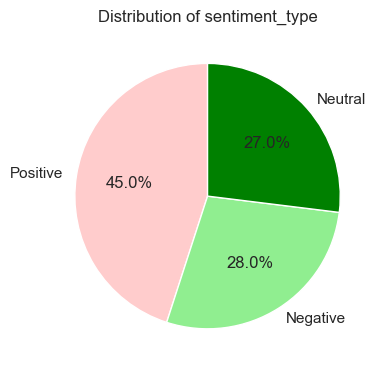

In [35]:
fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=False, figsize=(4, 4))

var = 'sentiment_type'
colors = ['#FFCCCC', 'lightgreen','green']
print(data[var].value_counts())
plt.pie(data[var].value_counts(), labels=['Positive', 'Negative','Neutral'], autopct='%1.1f%%', startangle=90, colors=colors)
plt.title(f'Distribution of {var}')

plt.tight_layout()

**DT is actually a positive guy!**

Show a few tweets:

In [36]:
data[data.sentiment_type=='POSITIVE'].text

1        ....in America, community by community where w...
2        On World AIDS Day, The First Lady and I expres...
6        RT @CNBC: This year is shaping up to be one of...
7        Just landed in the United Kingdom, heading to ...
8        The Fed should lower rates (there is almost no...
                               ...                        
13510    Mike Pence didn’t have the courage to do what ...
13511    Please support our Capitol Police and Law Enfo...
13512    I am asking for everyone at the U.S. Capitol t...
13514    These are the things and events that happen wh...
13517    The 75,000,000 great American Patriots who vot...
Name: text, Length: 6085, dtype: object

In [37]:
data[data.sentiment_type=='NEUTRAL'].text

4        “Trump did nothing impeachable, day-by-day rev...
10                                 https://t.co/zlfV4MOkom
12       "RT @thehill: #BREAKING: Ukraine's Zelensky: I...
26       “The Democrats don’t have any evidence, but th...
27       Breaking News: The President of Ukraine has ju...
                               ...                        
13507                          Even Mexico uses Voter I.D.
13509                              https://t.co/izItBeFE6G
13513                              https://t.co/Pm2PKV0Fp3
13516                              https://t.co/csX07ZVWGe
13518    To all of those who have asked, I will not be ...
Name: text, Length: 3644, dtype: object

In [38]:
data[data.sentiment_type=='NEGATIVE'].text

0        “Sen. Tim Scott Says Trump 'Innocent,' 'No Way...
3        “Schiff’s impeachment hearings wasting time wh...
5        Mini Mike Bloomberg has instructed his third r...
23       Heading to Europe to represent our Country and...
41       RT @RepMarkGreen: President Zelensky has repea...
                               ...                        
13495    RT @TomiLahren: The steal is in the making in ...
13498    Get smart Republicans. FIGHT! https://t.co/3fs...
13501    If Vice President @Mike_Pence comes through fo...
13505    They just happened to find 50,000 ballots late...
13506    The States want to redo their votes. They foun...
Name: text, Length: 3789, dtype: object

## Retweets per sentiment :

[Text(0.5, 1.0, 'Number of retweets per sentiment category')]

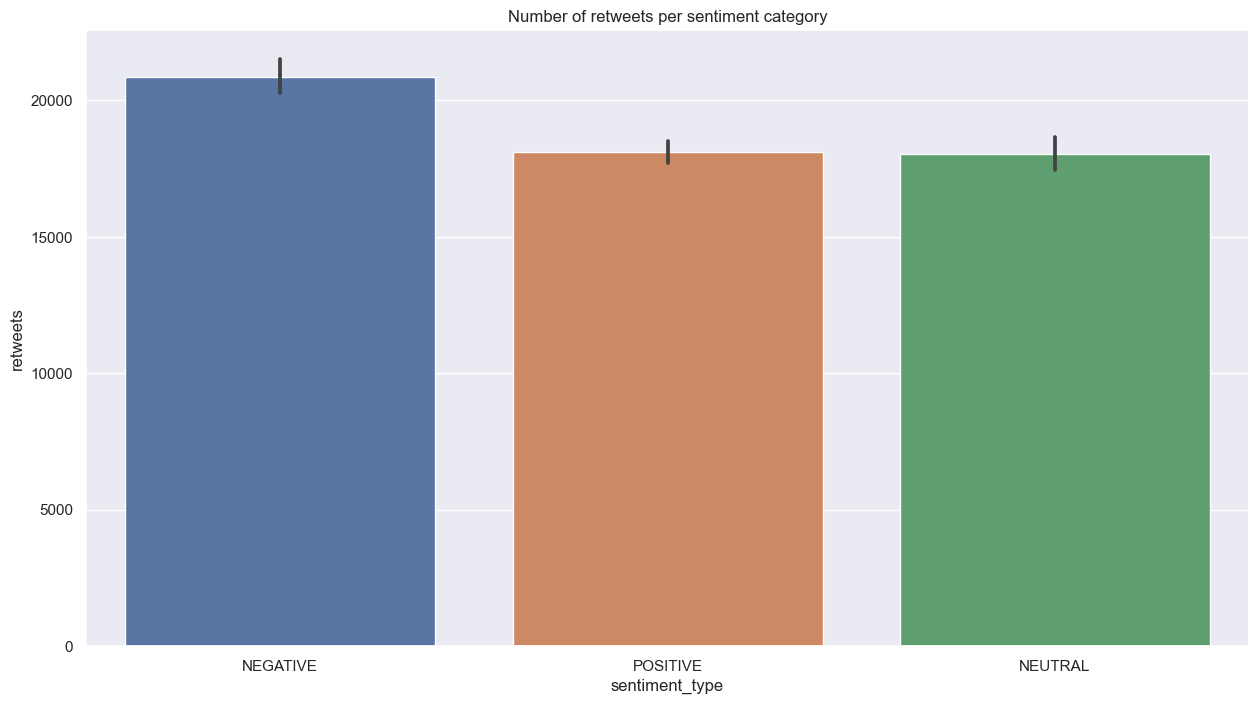

In [39]:
sns.barplot(data,x='sentiment_type',y='retweets').set(title='Number of retweets per sentiment category')


## Study relation between categories and sentiments:

In [40]:
pivot_dem = pd.crosstab(data[data['democrats']==True].democrats, data['sentiment_type'])
pivot_biden = pd.crosstab(data[data['biden']==True].biden, data['sentiment_type'])
pivot_covid = pd.crosstab(data[data['covid_related']==True].covid_related, data['sentiment_type'])
pivot_fake_news = pd.crosstab(data[data['is_fake_news']==True].is_fake_news, data['sentiment_type'])
pivot_vaccines = pd.crosstab(data[data['vaccines']==True].vaccines, data['sentiment_type'])

pivot_df = pd.concat([pivot_dem,pivot_biden,pivot_covid,pivot_fake_news,pivot_vaccines])
#pivot_df.reindex(index=['is_democrats_related','is_covid_related','is_fake_news_related','is_vaccines_related'])

In [41]:
proportion_df = 100*pivot_df.div(pivot_df.sum(axis=1), axis=0)
proportion_df

sentiment_type,NEGATIVE,NEUTRAL,POSITIVE
True,48.519362,13.097950,38.382688
True,44.317181,19.471366,36.211454
True,31.987578,21.739130,46.273292
True,68.888889,8.888889,22.222222
True,48.519362,13.097950,38.382688


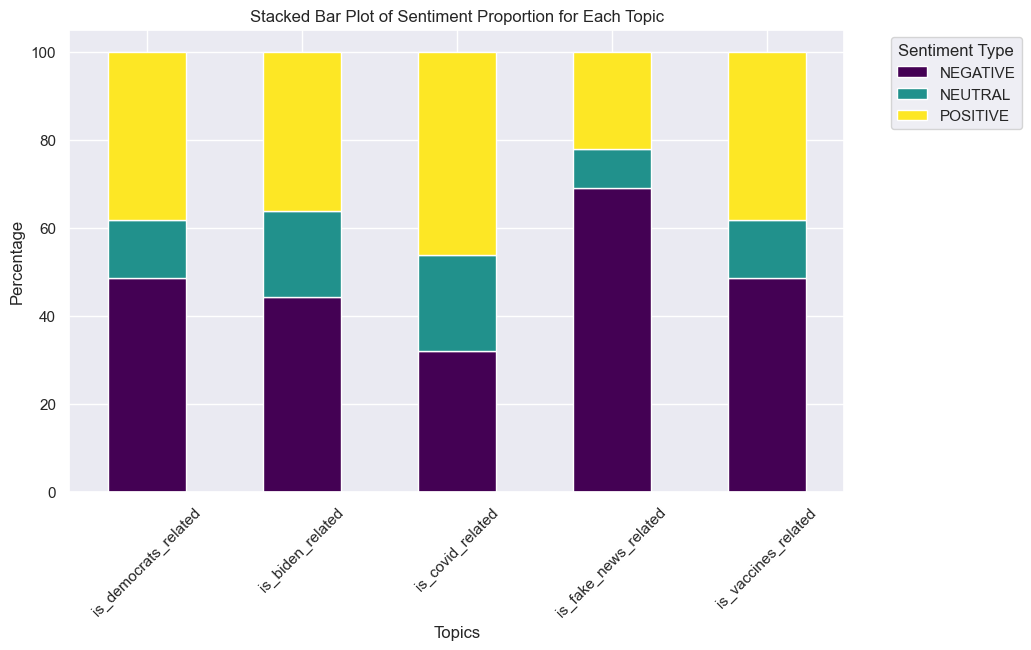

In [42]:
ax = proportion_df.plot(kind='bar', stacked=True, colormap='viridis', figsize=(10, 6))
plt.title('Stacked Bar Plot of Sentiment Proportion for Each Topic')
ax.set_xticklabels(['is_democrats_related','is_biden_related','is_covid_related','is_fake_news_related','is_vaccines_related'])
plt.xlabel('Topics')
plt.ylabel('Percentage')
plt.xticks(rotation=45)
plt.legend(title='Sentiment Type', bbox_to_anchor=(1.05, 1), loc='upper left')

## Retweets per sentiment for given categories ( to delete I guess)

[Text(0.5, 1.0, 'Number of retweets per sentiment category for covid related tweets')]

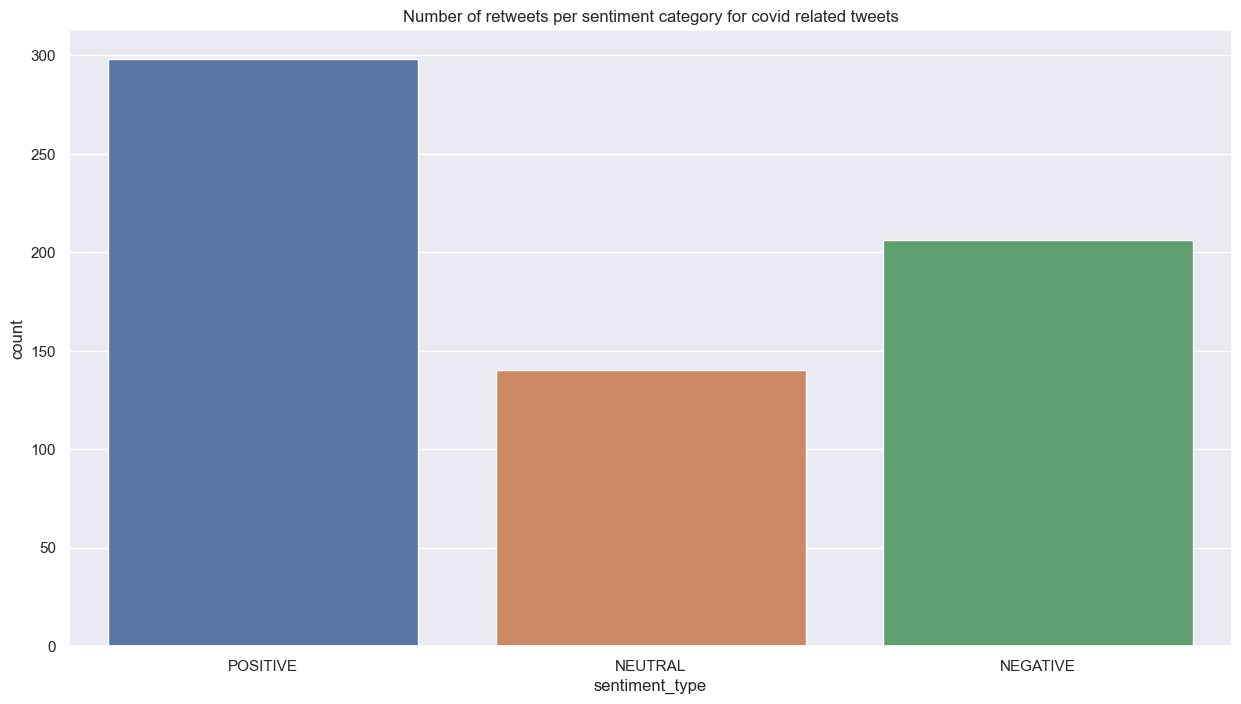

In [43]:

sns.countplot(data_covid_rel, x="sentiment_type").set(title='Number of retweets per sentiment category for covid related tweets')

[Text(0.5, 1.0, 'Number of retweets per sentiment categoryfor biden related tweets')]

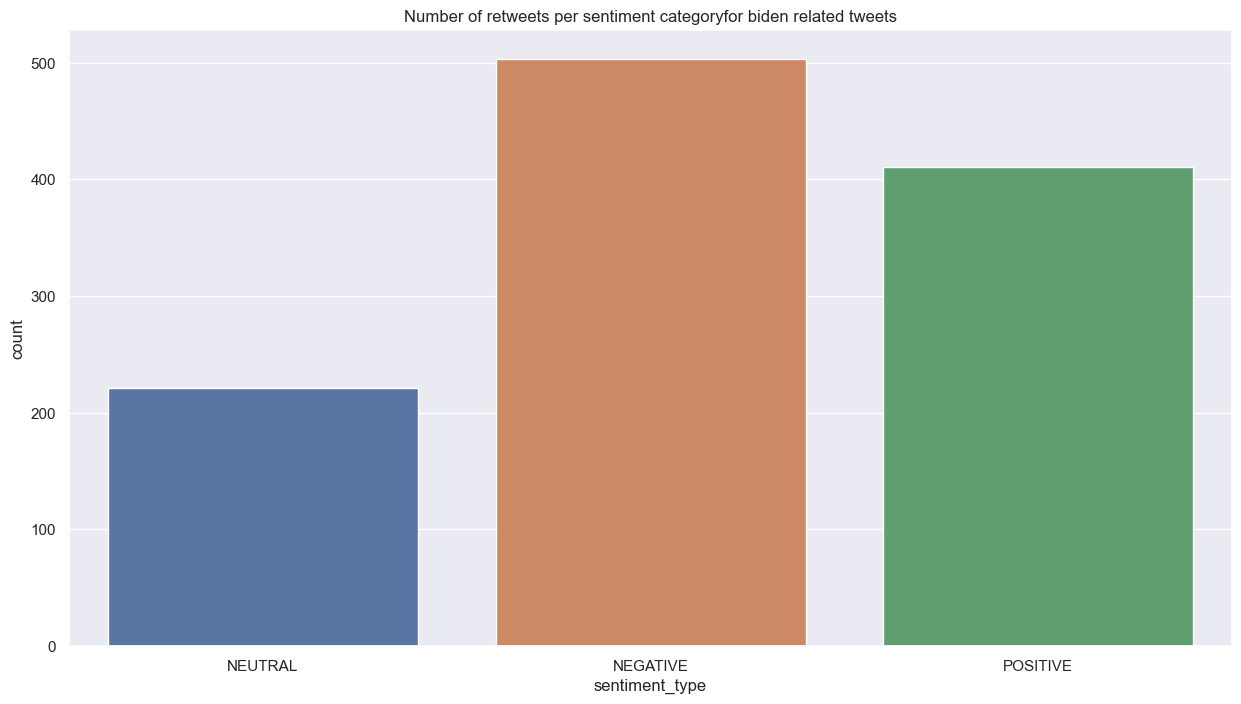

In [44]:
sns.countplot(data_biden_rel, x="sentiment_type").set(title='Number of retweets per sentiment categoryfor biden related tweets')

**Caution: some 'positive' are actually sarcastic:**

In [45]:
data_biden_rel[data_biden_rel.sentiment_type=='POSITIVE'].text[1720]

'Crazy Bernie takes the lead in the Democrat Primaries, but it is looking more and more like the Dems will never allow him to win! Will Sleepy Joe be able to stumble across the finish line?'

## Regression with one hotted categories :

In [46]:
mod_retweets = smf.ols(formula='retweets ~ C(is_democrats_related)+C(covid_related)+C(is_fake_news)+C(NEGATIVE)+C(POSITIVE)', data=data)
res_retweets = mod_retweets.fit()
print(res_retweets.summary())

                            OLS Regression Results                            
Dep. Variable:               retweets   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     24.43
Date:                Tue, 12 Dec 2023   Prob (F-statistic):           1.44e-24
Time:                        10:36:37   Log-Likelihood:            -1.5160e+05
No. Observations:               13518   AIC:                         3.032e+05
Df Residuals:                   13512   BIC:                         3.033e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

Covid ot big impacts but democrats does, negative has a significant positive impact
how to make meaningful regression?